# ASTR 596: FDS Homework 7: Gaussian Processes


### Last week, you worked on finding periodic planet signals in the light curve of Kepler-90, a star that is photometrically stable. The periodogram worked nicely because 

### a) we cleaned the light curve to squelch red noise
### b) the signals really were periodic and we could implictly make a strong assumption about the covariance between points.

### Life gets harder when the star itself has quasi-periodic variations because it has a magnetic field and is rotating (ruh oh...) 

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from astropy.table import Table
tab = Table.read('KIC2157356.txt',format='ascii')
tab['quarter'] = tab['quarter'].astype('int')
tab

time = tab['time'] # mel added
flux = tab['flux'] # mel added
dflux = tab['error'] # mel added

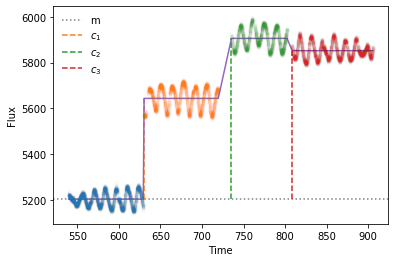

In [2]:
qs = sorted(np.unique(tab['quarter']))
means = []
cycle_map = {}
for i, q in enumerate(qs):
    ind = tab['quarter']==q
    t = tab[ind]
    plt.errorbar(t['time'], t['flux'], yerr=t['error'], marker='.', linestyle='None', alpha=0.01)
    meanflux = np.mean(t['flux'])
    cycle_map[q] = ind
    means.append(meanflux)
    if i == 0:
        plt.axhline(meanflux, label='m', color='grey', ls=":")
    else:

        vmin = means[0]
        vmax = meanflux

        plt.plot((t['time'][0], t['time'][0]), (vmin, vmax), label=rf'$c_{i}$', color=f'C{i}', ls='--') 

plt.xlabel('Time')
plt.ylabel('Flux')
plt.legend(frameon=False)


# MEL ADDED BELOW
all_times = tab['time']
one_times = np.ones(len(all_times))

m, c1, c2, c3 = means[0], means[1], means[2], means[3]

q6 = one_times[cycle_map[6]]
q7 = one_times[cycle_map[7]]
q8 = one_times[cycle_map[8]]
q9 = one_times[cycle_map[9]]

model_y = np.concatenate((q6*m, q7*(c1), q8*(c2), q9*(c3)))

plt.plot(all_times, model_y)
plt.show()

### As you can see there is some kind of periodic singal, but it's not perfectly regular. There is also the usual offsets between Kepler photometry in different cycles.

### You'll need four parameters to describe constants ($m, c_1, c_2, c_3$) to renormalize the flux to the first cycle, illustrated in the figure above. 
### $m$ specifies the mean of the Gaussian process, while $c_1, c_2, c_3$ are nuisance parameters. 

### You know how to implement a model with one common zeropoint and multiple offsets - this was what you did on your midterm.


### You'll also need some model to describe the quasi-periodic oscillations. There's no good way to write down a model in real for these in real space because stellar magnetic fields are incredibly complicated. 

### Instead we'll write down a model for the covariance between the observations and use a Gaussian process to model the star. You can model quasi-periodic correlation structure as something periodic + something that varies the periodicity smoothly:

## $$k(t_i, t_j) = A\cdot \exp\left(-\Gamma_1\cdot \sin^2\left(\frac{\pi}{P}|t_i - t_j|\right) -  \frac{|t_i-t_j|^2}{\lambda}) \right) $$

### This is another 4 parameters, ($A, \Gamma_1, P, \lambda$) parameters for a total of 8: ($m, c_1, c_2, c_3, A, \Gamma_1, P, \lambda$)


<hr>

### Q1: To implement the GP correlations, use the `george` package to construct this quasi-periodic kernel
https://george.readthedocs.io/en/latest/user/kernels/


### In particular, you should be able to combine `ExpSine2Kernel` and `ExpSquaredKernel` to get a model for the quasi-periodic oscillations.

In [3]:
import george
import emcee
import corner
from george import kernels
from george.modeling import Model
from scipy.optimize import curve_fit, minimize

import matplotlib as mpl
mpl.rcParams['axes.labelsize'] = 16
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16
mpl.rcParams['font.size'] = 16
mpl.rcParams['font.family'] = 'Cambria' #'serif' Cambria, Times New Roman, Georgia

In [4]:
# construct quasi-periodic kernel using both stationary and non-stationary components
spaced_pts = 50    #10 100
A_init = 7.0       #7.3 7.5 1.0
gamma_init = 0.2  #0.2 -0.2 0.1
P_init = 1.0       #2.5 0.8 5.0
lambda_init = 2.0  #2.2 1.8 2.0

k1 = kernels.ExpSine2Kernel(gamma=gamma_init, log_period=P_init)
k2 = kernels.ExpSquaredKernel(metric=lambda_init)
quasi_kernel = A_init*(k1 * k2)

### Q2: To implement the full model, read how to use `george`'s modeling protocol:
https://george.readthedocs.io/en/latest/tutorials/model/

In [5]:
class LargeModesModel(Model):
    parameter_names = ('m', 'c1', 'c2', 'c3')
    def set_vector(self, p): # alex said we need this...
        self.m, self.c1, self.c2, self.c3 = p
    def get_value(self, t):
        all_times = tab['time']
        time6 = all_times[cycle_map[6]]
        time7 = all_times[cycle_map[7]]
        time8 = all_times[cycle_map[8]]
        time9 = all_times[cycle_map[9]]
        
        t = t.flatten()
        flux = np.array([])
        for i in t:
            if min(time6) <= i < min(time7): #max(time6):
                flux = np.append(flux, self.m)
            elif min(time7) <= i < min(time8): #max(time7):
                flux = np.append(flux, (self.m+self.c1))
            elif min(time8) <= i < min(time9): #max(time8):
                flux = np.append(flux, (self.m+self.c2))
            elif min(time9) <= i <= max(time9):
                flux = np.append(flux, (self.m+self.c3))
            elif i < min(time6) or i > max(time9):
                print('t {} is outside range'.format(i))
            else:
                print('time {}, something weird is happening'.format(i))
        return flux
            
m_init = means[0] #5188 5190 means[0]
c1_init = means[1] - means[0] #455 450 means[1] - means[0]
c2_init = means[2] - means[0] #739 725 means[2] - means[0]
c3_init = means[3] - means[0] #650 660 means[3] - means[0]

gp = george.GP(mean=LargeModesModel(m=m_init, c1=c1_init, c2=c2_init, c3=c3_init), kernel=quasi_kernel)

### Q3: With your model and likelihood constructured, write down priors on the parameters (you should be able to estimate from the plots)

In [6]:
gp.get_parameter_dict()

OrderedDict([('mean:m', 5203.7993840014005),
             ('mean:c1', 440.0274367497468),
             ('mean:c2', 702.2100400396093),
             ('mean:c3', 648.388347271658),
             ('kernel:k1:log_constant', 1.9459101490553132),
             ('kernel:k2:k1:gamma', 0.2),
             ('kernel:k2:k1:log_period', 1.0),
             ('kernel:k2:k2:metric:log_M_0_0', 0.6931471805599453)])

In [7]:
def lnprob(p):
    if (p[0] < 5100) or (p[0] > 5300): # prior on m
        return -np.inf
    if (p[1] < 400) or (p[1] > 500): # prior on c1
        return -np.inf
    if (p[2] < 650) or (p[2] > 750): # prior on c2
        return -np.inf
    if (p[3] < 600) or (p[3] > 700): # prior on c3
        return -np.inf
    if (p[4] < -50.0) or (p[4] > 50.0): # prior on log_constant
        return -np.inf
    if (p[5] < -50.0) or (p[5] > 50.0): # prior on gamma
        return -np.inf
    if (p[6] < -50.0) or (p[6] > 50.0): # prior on log_period
        return -np.inf
    if (p[7] < -10.0) or (p[7] > 10.0): # prior on lambda (metric)
        return -np.inf
    
    gp.set_parameter_vector(p)
    return gp.log_likelihood(flux[::spaced_pts], quiet=True) + gp.log_prior()

### Q4: Use `emcee` to optimize the model parameters and hyper-parameters, **using only every 10th sample in time**
### (Don't go overboard with the number of walkers or steps)
https://george.readthedocs.io/en/latest/tutorials/hyper/ may help

In [8]:
# from "hyperparameters"
gp.compute(time[::spaced_pts])

nwalkers, ndim = 32, len(gp)
nsteps, nburnin = 200, 20
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob)

p0 = gp.get_parameter_vector() + np.random.randn(nwalkers, ndim)

print("Running burn-in")
p0, _, _ = sampler.run_mcmc(p0, nburnin, progress=True)

print("Running production chain")
chain = sampler.run_mcmc(p0, nsteps, progress=True)

Running burn-in


  0%|          | 0/20 [00:00<?, ?it/s]/opt/miniconda3/envs/fds/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 20/20 [19:14<00:00, 57.72s/it]


Running production chain


100%|██████████| 200/200 [3:37:18<00:00, 65.19s/it]  


Text(0.5, 0, 'Step')

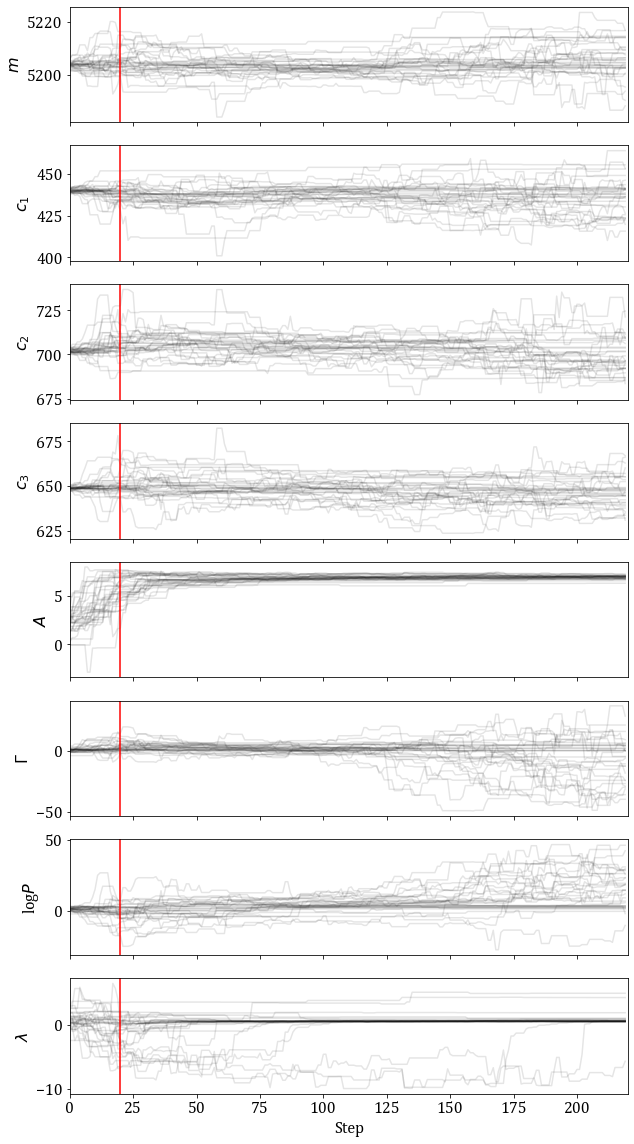

In [9]:
samp = sampler.get_chain()

labels = [r'$m$', r'$c_1$', r'$c_2$', r'$c_3$', r'$A$', r'$\Gamma$', r'log$P$', r'$\lambda$']

fig, axs = plt.subplots(nrows=ndim, ncols=1, figsize=(10, 20), sharex=True)
for i in range(ndim):
    ax = axs[i]
    ax.plot(samp[:,:,i], color='k', alpha=0.1 )
    ax.set_ylabel(labels[i])
    ax.set_xlim(0, nburnin+nsteps)
    ax.axvline(nburnin, color='red')
ax.set_xlabel('Step')

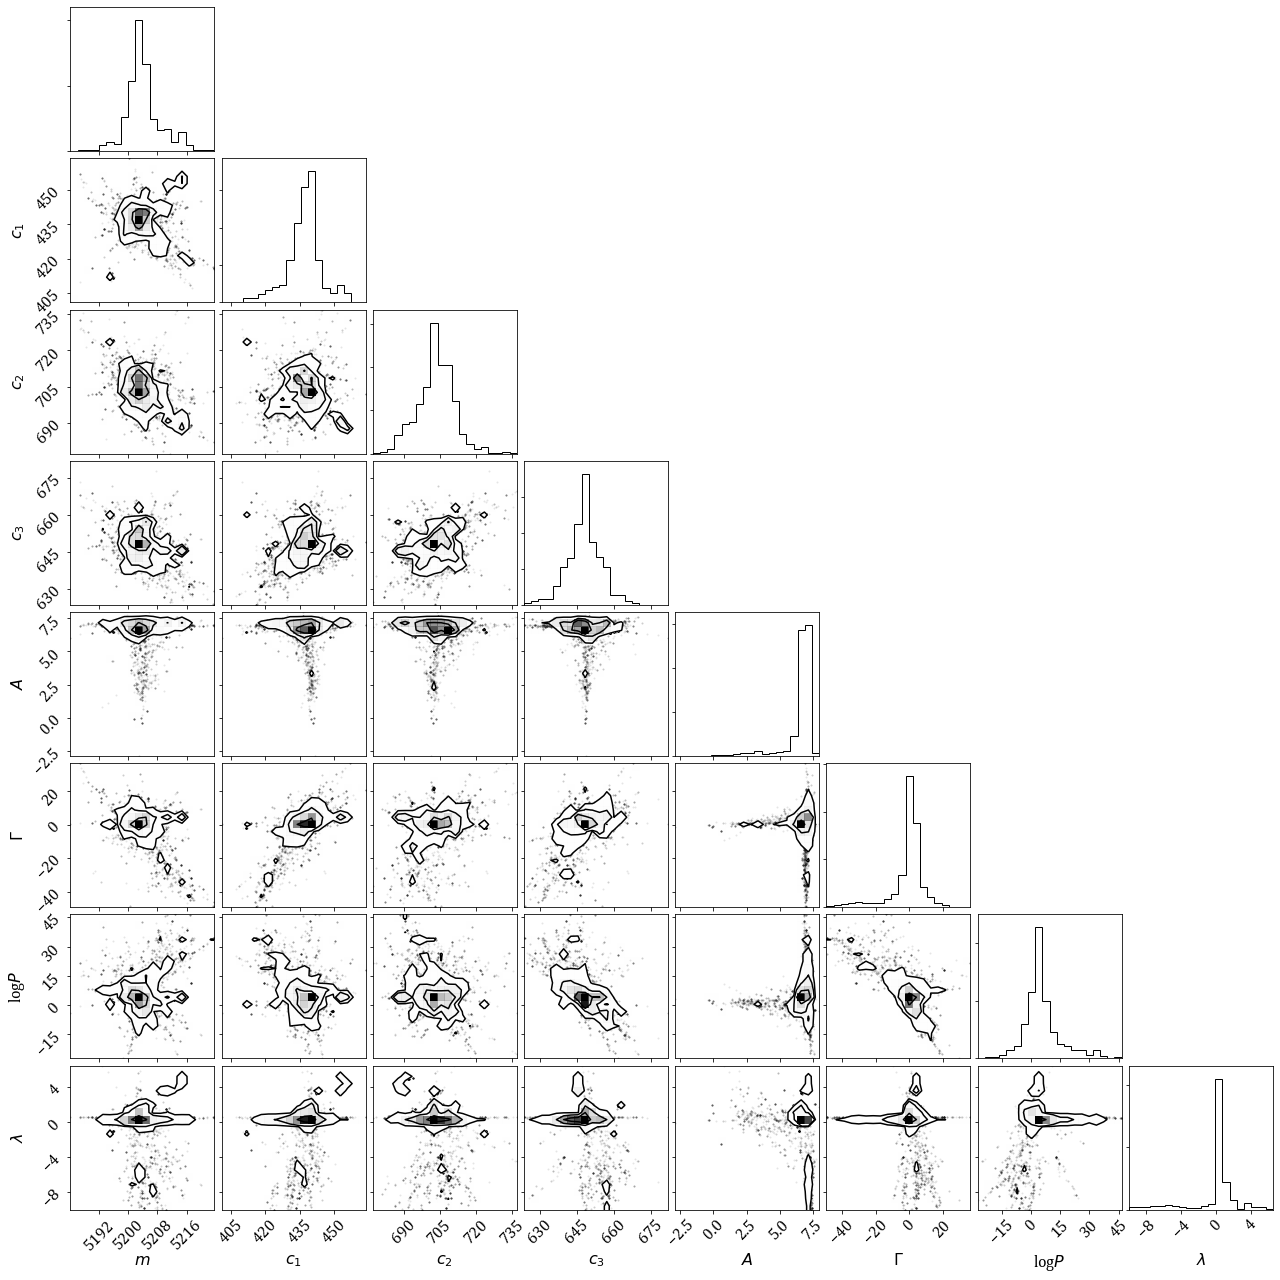

In [10]:
flat_samples = sampler.get_chain(flat=True)
fig = corner.corner(flat_samples, labels=labels) 

### Q5: Plot your posterior model over the data after correcting for the offsets, showing the points you used to condition the GP in red, and the remaining data in black. 

Text(0.5, 1.0, 'Posterior models over GP conditioned data')

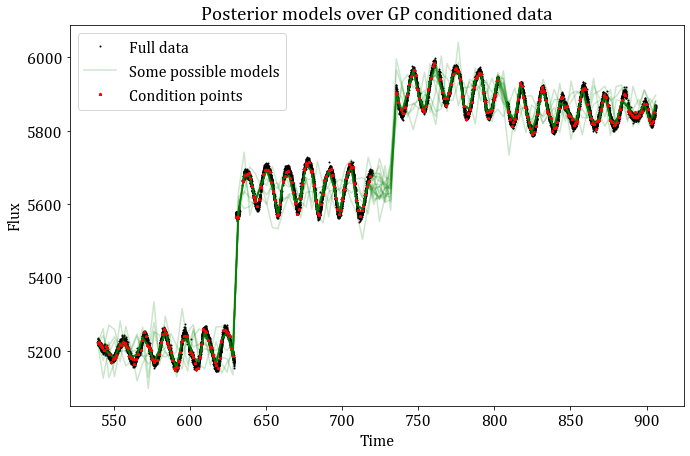

In [31]:
x = np.linspace(min(time), max(time), 100)

fig = plt.figure(figsize=(11,7))
plt.plot(time, flux, '.k', ms=2, label='Full data')
for i in range(20):
    w = np.random.randint(sampler.chain.shape[0])
    n = np.random.randint(20, 220) # explicitly excluding burn-in
    gp.set_parameter_vector(sampler.chain[w, n])

    samp = gp.sample_conditional(flux[::spaced_pts], x)
    if i == 0:
        plt.plot(x, samp, 'g', alpha=0.2, label='Some possible models')
    else:
        plt.plot(x, samp, 'g', alpha=0.2)
plt.plot(time[::spaced_pts], flux[::spaced_pts], '*r', ms=3, label='Condition points')
plt.xlabel('Time')
plt.ylabel('Flux')
plt.legend()
plt.title('Posterior models over GP conditioned data')

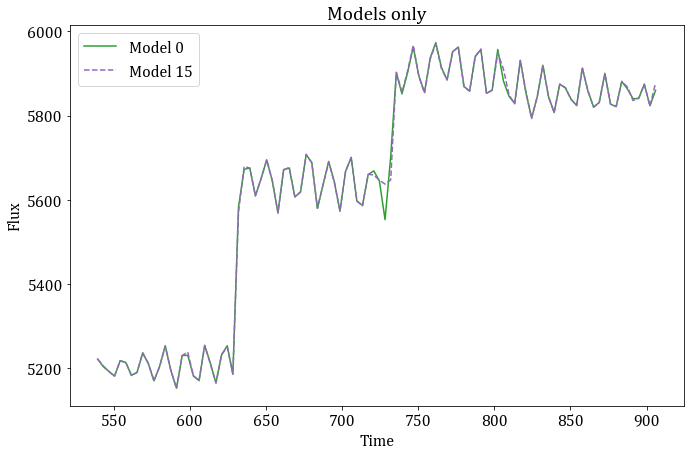

In [32]:
fig = plt.figure(figsize=(11,7))
gp.set_parameter_vector(sampler.chain[0, 219])
samp = gp.sample_conditional(flux[::spaced_pts], x)
plt.plot(x, samp, 'C2-', label='Model 0')
gp.set_parameter_vector(sampler.chain[15, 219])
samp = gp.sample_conditional(flux[::spaced_pts], x)
plt.plot(x, samp, 'C4--', label='Model 15')
plt.xlabel('Time')
plt.ylabel('Flux')
plt.legend()
plt.title('Models only')
plt.show()

Mismatch between walkers is at the boundary between quarters.